## Visualization of the Dataset

In [1]:
import torch
print("torch.__version__: ",torch.__version__)
torch.cuda.is_available()
import matplotlib.pyplot as plt
import cv2
import torch

torch.__version__:  2.0.1+cu117


In [2]:
# import dataset
PATH_IMG_ROOT = './data/train_true_color/'
PATH_LBL_ROOT = '/data/train_mask/'
PATH_OUTPUT = './eda/'

BANDS = ['B02', 'B03', 'B04']
COLORS = ['#0000ff', '#00ff7f', 'darkorange']
CMAPS = ['Blues', 'Greens', 'Reds']

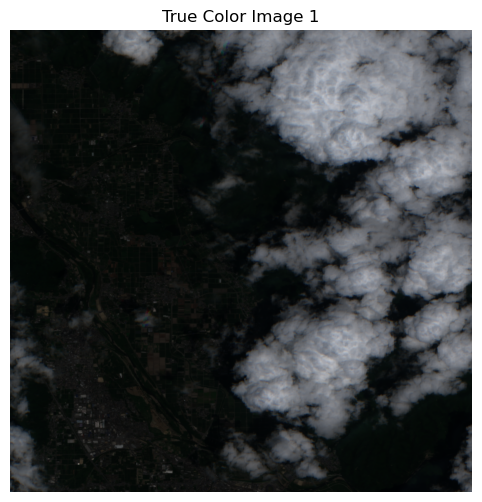

In [5]:
def normalize_image_to_8bit(img):
    """Normalize the image to fit within [0, 255] range."""
    img_normalized = cv2.normalize(img, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    return img_normalized

def display_true_color_image(image_idx):
    """Display an image in its original color."""
    
    # Construct image path
    img_path = f"./data/train_true_color/train_true_color_{image_idx}.tif"
    
    # Read image
    img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
    
    # Normalize to 8-bit
    img_8bit = normalize_image_to_8bit(img)

    # Convert the image from BGR to RGB
    img_rgb = cv2.cvtColor(img_8bit, cv2.COLOR_BGR2RGB)

    # Display the image
    plt.figure(figsize=(10, 6))
    plt.imshow(img_rgb)
    plt.title(f'True Color Image {image_idx}')
    plt.axis('off')  # To hide axis values
    plt.show()

# Image index to visualize
image_idx = 1

display_true_color_image(image_idx)


/tmp/ipykernel_12081/1189822538.py:58: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


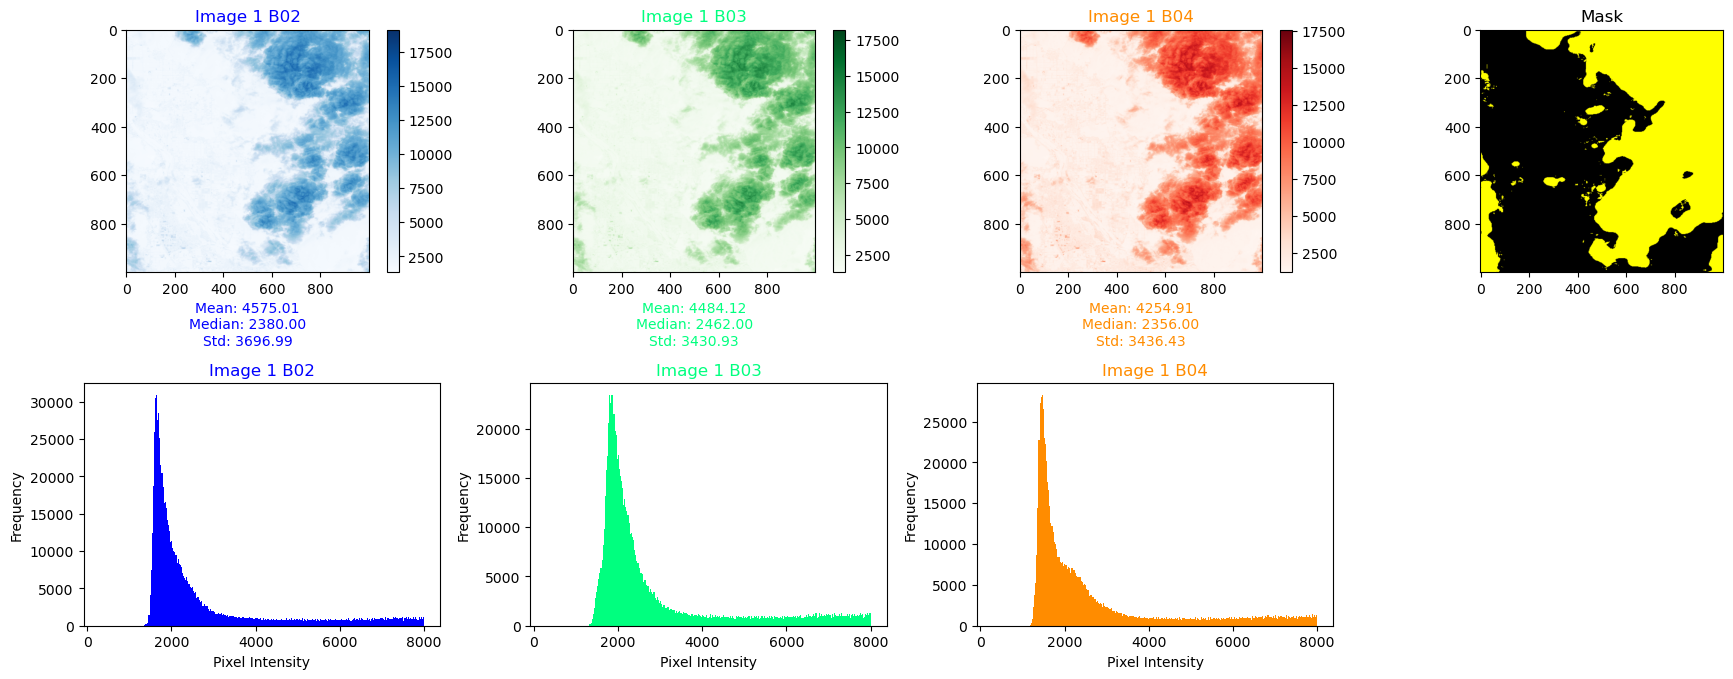

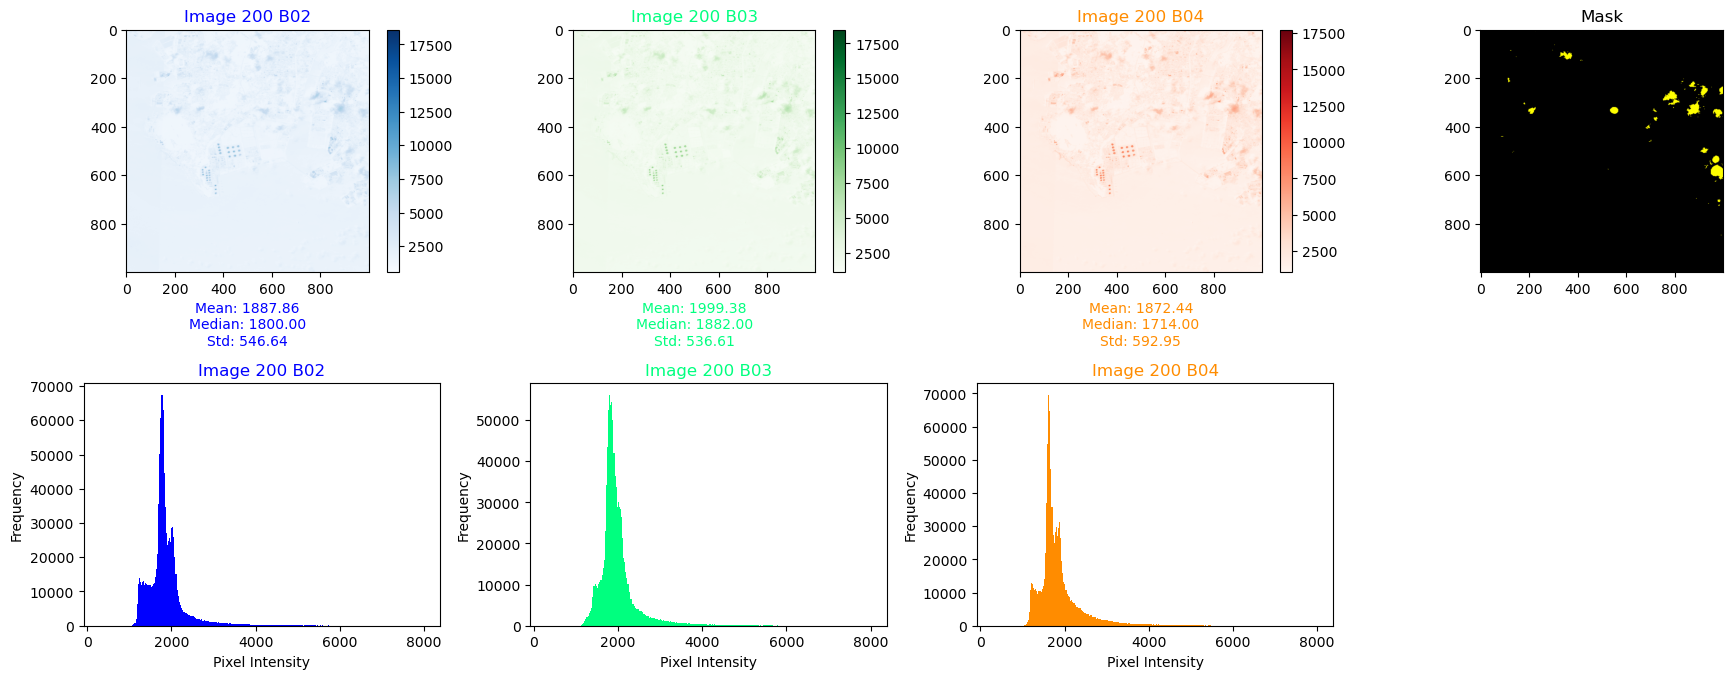

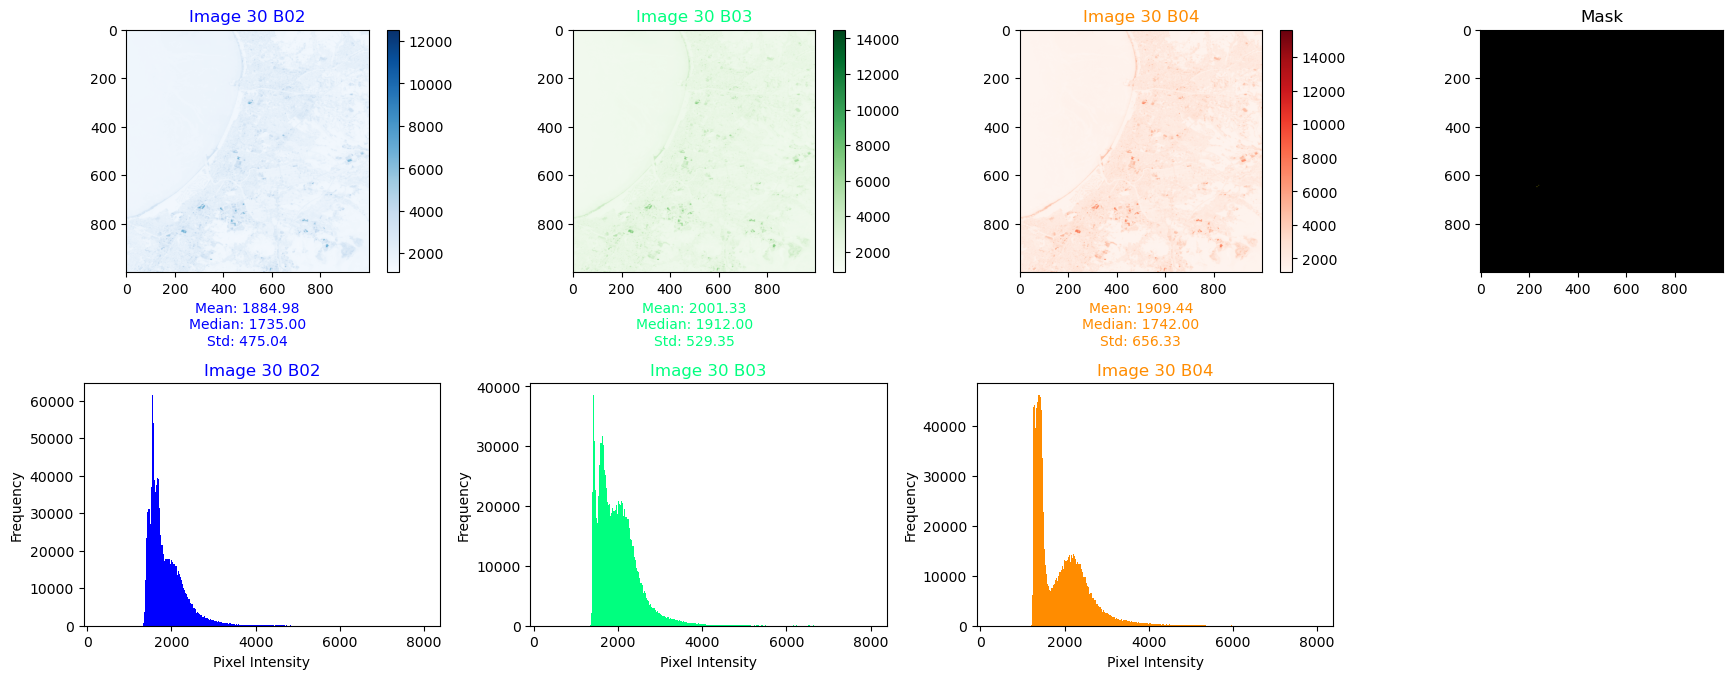

In [64]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def display_image_and_histogram(image_idx):
    """Display the three bands and their histograms for a given image index."""
    img_path = f"./data/train_true_color/train_true_color_{image_idx}.tif"
    mask_path = f"./data/train_mask/train_mask_{image_idx}.tif"

    # Load the image and its corresponding mask
    img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
    mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)

    # Split the three bands
    B2, B3, B4 = cv2.split(img)

    BANDS = ['B02', 'B03', 'B04']
    COLORS = ['#0000ff', '#00ff7f', 'darkorange']
    CMAPS = ['Blues', 'Greens', 'Reds']
    bands = [B2, B3, B4]

    plt.figure(figsize=(18, 10))

    # Display the bands
    for idx, (band, cmap, title, color) in enumerate(zip(bands, CMAPS, BANDS, COLORS)):
        ax = plt.subplot(3, 4, idx + 1)
        img = ax.imshow(band, cmap=cmap)
        
        mean = np.mean(band)
        median = np.median(band)
        std_dev = np.std(band)
        min_val = np.min(band)
        max_val = np.max(band)
        
        stats_text = f'Mean: {mean:.2f}\nMedian: {median:.2f}\nStd: {std_dev:.2f}'
        
        # Display statistics below the image
        ax.set_xlabel(stats_text, color=color, fontsize=10)
        
        plt.title(f'Image {image_idx} {title}', color=color)
        plt.colorbar(img, ax=ax, orientation='vertical')
        

    # Display the corresponding mask/label
    plt.subplot(3, 4, 4)
    import matplotlib.colors as mcolors
    custom_cmap = mcolors.LinearSegmentedColormap.from_list("mycmap", ['black', 'yellow'])
    plt.imshow(mask,cmap=custom_cmap)
    plt.title('Mask')

    # Display filled histograms for the bands
    for idx, (band, title, color) in enumerate(zip(bands, BANDS, COLORS)):
        plt.subplot(3, 4, idx + 5)
        plt.hist(band.ravel(), color=color, bins=300, range=(300, 8000))
        plt.title(f'Image {image_idx} {title}', color=color)
        plt.xlabel('Pixel Intensity')
        plt.ylabel('Frequency')
        plt.tight_layout()

    plt.show()

# List of image indices to visualize
image_indices = [1, 200, 30]  # Extend this list as needed

for idx in image_indices:
    display_image_and_histogram(idx)


(1000, 1000, 3)
850 15640
(1000, 1000)


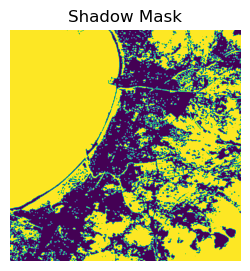

In [69]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
def detect_cloud_shadow(image):
    # Compute Darkness Index
    DI = np.mean(image, axis=-1)
    
    # Empirically determined threshold (can be optimized)
    # Alternatively, you can use Otsu's thresholding from skimage.filters
    from skimage.filters import threshold_otsu
    threshold = threshold_otsu(DI)
    
    shadow_mask = DI < threshold
    
    return shadow_mask

# Sample usage
# image_idx = 1
# image = f"./data/train_true_color/train_true_color_{image_idx}.tif"
# shadow_mask = detect_cloud_shadow(image)

# If you need to use morphological operations, you can use `binary_opening` or `binary_closing` 
# from `skimage.morphology` to refine the shadow mask.
# use `binary_dilation` or `binary_erosion` to expand or shrink the mask.
from skimage.morphology import binary_opening, binary_closing, binary_dilation, binary_erosion

# Sample usage
image_idx = 30
img_path = f"./data/train_true_color/train_true_color_{image_idx}.tif"
from tifffile import imread
image = imread(img_path)
print(image.shape)
print(image.min(), image.max())
shadow_mask = detect_cloud_shadow(image)
refined_shadow_mask = binary_opening(shadow_mask, np.ones((3, 3)))
print(shadow_mask.shape)
# Display the shadow mask
plt.figure(figsize=(3, 3))
plt.imshow(refined_shadow_mask)
plt.title('Shadow Mask')
plt.axis('off')
plt.show()

(1000, 1000, 3)
1182 19136
(1000, 1000)


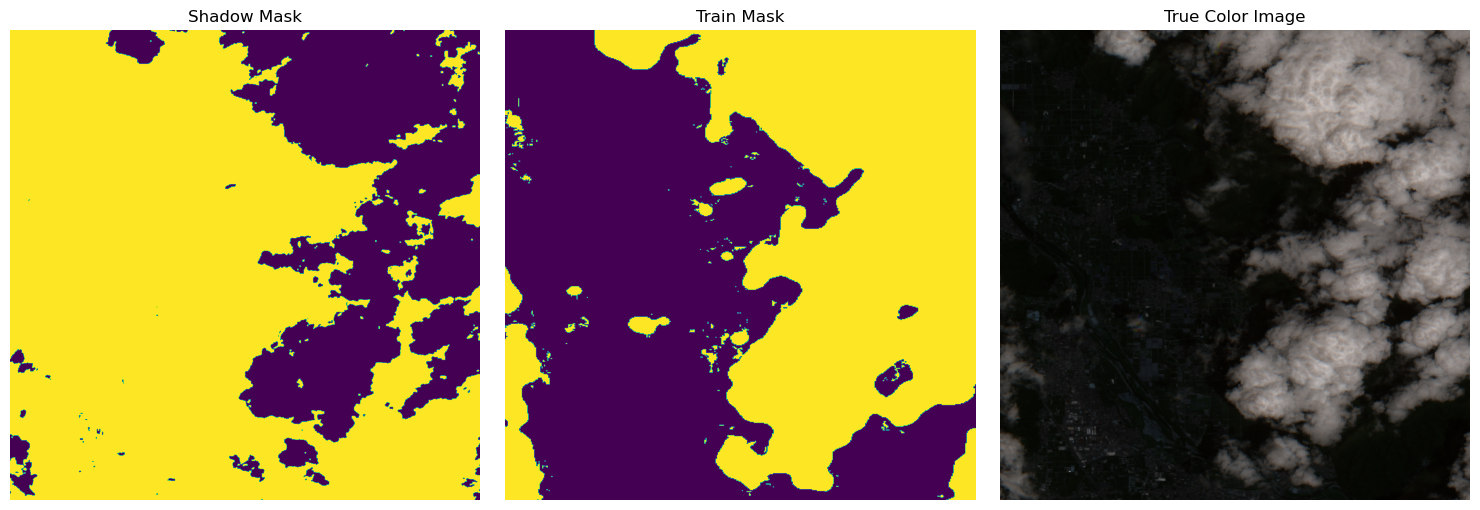

In [76]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
def normalize_image_to_8bit(img):
    """Normalize the image to fit within [0, 255] range."""
    img_normalized = cv2.normalize(img, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    return img_normalized

def detect_cloud_shadow(image):
    # Compute Darkness Index
    DI = np.mean(image, axis=-1)
    
    # Empirically determined threshold (can be optimized)
    # Alternatively, you can use Otsu's thresholding from skimage.filters
    from skimage.filters import threshold_otsu
    threshold = threshold_otsu(DI)
    
    shadow_mask = DI < threshold
    
    return shadow_mask

# If you need to use morphological operations, you can use `binary_opening` or `binary_closing` 
# from `skimage.morphology` to refine the shadow mask.
# use `binary_dilation` or `binary_erosion` to expand or shrink the mask.
from skimage.morphology import binary_opening, binary_closing, binary_dilation, binary_erosion

image_idx = 1
img_path = f"./data/train_true_color/train_true_color_{image_idx}.tif"
mask_path = f"./data/train_mask/train_mask_{image_idx}.tif"

from tifffile import imread
image = imread(img_path)
train_mask = imread(mask_path)

print(image.shape)
print(image.min(), image.max())
shadow_mask = detect_cloud_shadow(image)
refined_shadow_mask = binary_opening(shadow_mask, np.ones((3, 3)))
print(shadow_mask.shape)

# Display the shadow mask next to train_mask, and image
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.imshow(refined_shadow_mask)
ax1.set_title('Shadow Mask')
ax1.axis('off')

ax2.imshow(train_mask)
ax2.set_title('Train Mask')
ax2.axis('off')

img_8bit = normalize_image_to_8bit(image)
# Convert the image from BGR to RGB
img_rgb = cv2.cvtColor(img_8bit, cv2.COLOR_BGR2RGB)
ax3.imshow(img_rgb)
ax3.set_title('True Color Image')
ax3.axis('off')

plt.tight_layout()
plt.show()


### Cloud Coverage

Mean Cloud Coverage: 19.47%
Median Cloud Coverage: 5.75%
Standard Deviation: 26.96
Minimum Cloud Coverage: 0.00%
Maximum Cloud Coverage: 100.00%


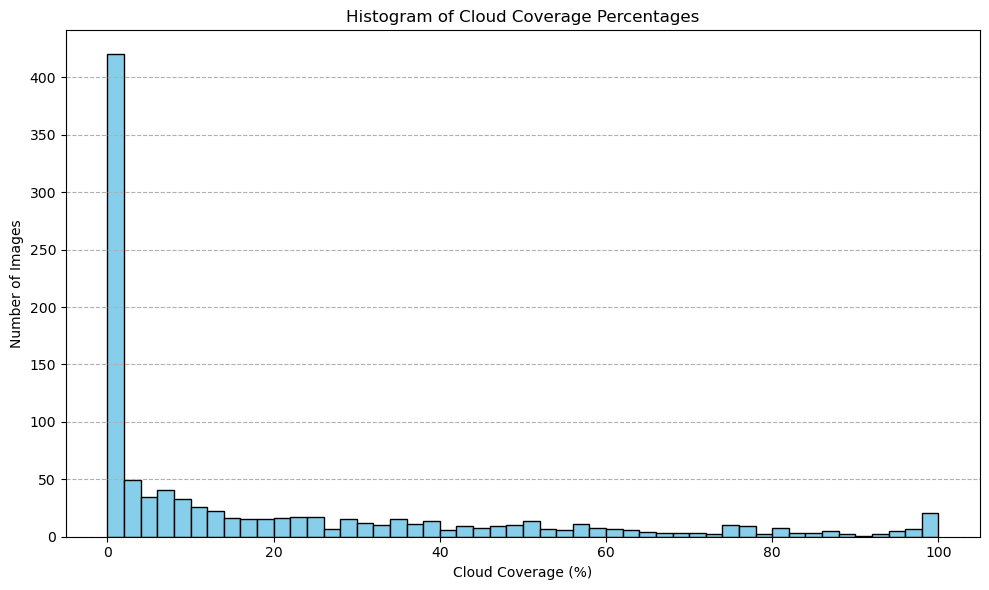

In [5]:
def calculate_cloud_coverage(mask):
    """Calculate the percentage of pixels marked as cloud in a mask image."""
    total_pixels = mask.size
    cloud_pixels = np.sum(mask)
    return (cloud_pixels / total_pixels) * 100

def cloud_coverage_histogram():
    """ Plot a histogram of cloud coverage percentages for the training dataset."""
    cloud_percentages = []

    # Loop through all mask images and calculate cloud coverage
    for idx in range(1000):  # As there are 1000 mask images
        mask_path = f"./data/train_mask/train_mask_{idx}.tif"
        mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
        cloud_coverage = calculate_cloud_coverage(mask)
        cloud_percentages.append(cloud_coverage)


        # Statistics
    mean_coverage = np.mean(cloud_percentages)
    median_coverage = np.median(cloud_percentages)
    std_coverage = np.std(cloud_percentages)
    min_coverage = np.min(cloud_percentages)
    max_coverage = np.max(cloud_percentages)

    print(f"Mean Cloud Coverage: {mean_coverage:.2f}%")
    print(f"Median Cloud Coverage: {median_coverage:.2f}%")
    print(f"Standard Deviation: {std_coverage:.2f}")
    print(f"Minimum Cloud Coverage: {min_coverage:.2f}%")
    print(f"Maximum Cloud Coverage: {max_coverage:.2f}%")
    # Plot a histogram of cloud coverage percentages
    plt.figure(figsize=(10, 6))
    plt.hist(cloud_percentages, bins=50, color='skyblue', edgecolor='black')
    plt.title('Histogram of Cloud Coverage Percentages')
    plt.xlabel('Cloud Coverage (%)')
    plt.ylabel('Number of Images')
    plt.grid(axis='y', linestyle='--')
    plt.tight_layout()
    plt.show()

# Call the function to see the histogram
cloud_coverage_histogram()


On average, around `19.47%` of each image in the dataset is covered by clouds, but half of the images have a mere `5.75%` or less cloud coverage. This discrepancy, highlighted by the significantly lower median compared to the mean, indicates that while a vast majority of the dataset consists of clear to minimally cloudy images, there are a few that are heavily clouded. The dataset showcases a broad variability, as depicted by the standard deviation of `26.96%`, ranging from completely clear skies to images entirely obscured by clouds.

### Correlation Analysis

In [6]:
import numpy as np
import cv2

# Initialize variables to store sum of intensities
sum_cloud_intensity = {band: 0 for band in BANDS}
sum_noncloud_intensity = {band: 0 for band in BANDS}
count_cloud = {band: 0 for band in BANDS}
count_noncloud = {band: 0 for band in BANDS}

# Iterate over all images
for idx in range(1000):  
    img_path = f"./data/train_true_color/train_true_color_{idx}.tif"
    mask_path = f"./data/train_mask/train_mask_{idx}.tif"
    
    img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
    mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
    
    for band_idx, band_name in enumerate(BANDS):
        band_data = img[:, :, band_idx]
        
        cloud_pixels = band_data[mask == 1]
        noncloud_pixels = band_data[mask == 0]
        
        sum_cloud_intensity[band_name] += np.sum(cloud_pixels)
        sum_noncloud_intensity[band_name] += np.sum(noncloud_pixels)
        
        count_cloud[band_name] += len(cloud_pixels)
        count_noncloud[band_name] += len(noncloud_pixels)

# Calculate mean intensity
mean_cloud_intensity = {band: sum_cloud_intensity[band] / count_cloud[band] for band in BANDS}
mean_noncloud_intensity = {band: sum_noncloud_intensity[band] / count_noncloud[band] for band in BANDS}

print("Mean Intensity for Cloud Regions:", mean_cloud_intensity)
print("Mean Intensity for Non-Cloud Regions:", mean_noncloud_intensity)

Mean Intensity for Cloud Regions: {'B02': 5528.147553131795, 'B03': 5284.638814096459, 'B04': 5077.995628482972}
Mean Intensity for Non-Cloud Regions: {'B02': 1674.1629455920702, 'B03': 1778.2732843075305, 'B04': 1647.4195726215232}


Clouds generally reflect more light, leading to higher pixel intensity values across all bands.
The intensity difference between cloud and non-cloud regions is most pronounced in the `B02` band, followed by `B03` and then `B04`. This suggests that the `B02` band might be particularly sensitive to clouds, making it a potentially valuable feature for cloud detection.
Even though `B03` has a slightly higher intensity for non-cloud regions than `B04`, its intensity for cloud regions is also significantly higher, emphasizing its utility for differentiation.

### Spatial Patterns

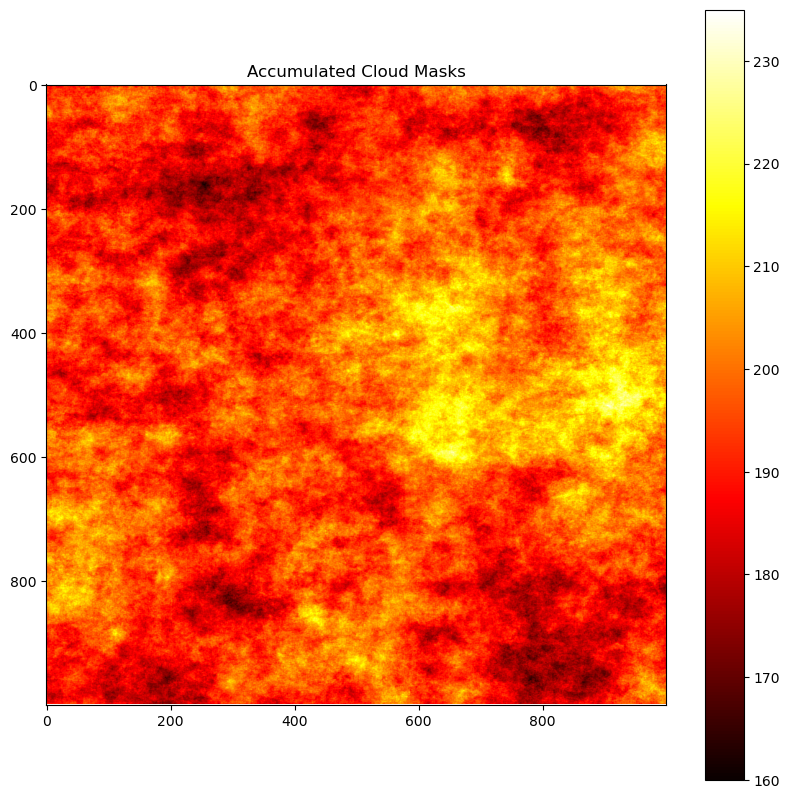

Mean Cloud Presence in Central Region: 197.8
Mean Cloud Presence in Edge Region: 148.305364


In [7]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Initialize accumulator
accumulator = np.zeros_like(cv2.imread("./data/train_mask/train_mask_0.tif", cv2.IMREAD_UNCHANGED))

# Aggregate masks
for idx in range(1000):
    mask_path = f"./data/train_mask/train_mask_{idx}.tif"
    mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
    accumulator += mask

# Visualize the aggregated mask
plt.figure(figsize=(10, 10))
plt.imshow(accumulator, cmap='hot')
plt.colorbar()
plt.title('Accumulated Cloud Masks')
plt.show()


# Define central and edge regions
height, width = accumulator.shape
center_h, center_w = height // 2, width // 2
central_region = accumulator[center_h - 25:center_h + 25, center_w - 25:center_w + 25]
edge_region = accumulator - cv2.resize(central_region, (width, height))

# Compute mean cloud presence in regions
mean_center = np.mean(central_region)
mean_edge = np.mean(edge_region)

print(f"Mean Cloud Presence in Central Region: {mean_center}")
print(f"Mean Cloud Presence in Edge Region: {mean_edge}")

Percentage Difference between Central and Edge regions:

$$
\text{Percentage Difference} = \left( \frac{\text{Central} - \text{Edge}}{\text{Edge}} \right) \times 100\% = 33\%
$$

Clouds appear 33% more often in the center of images than at the edges. This pattern may suggests the model should be focused more on central regions.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


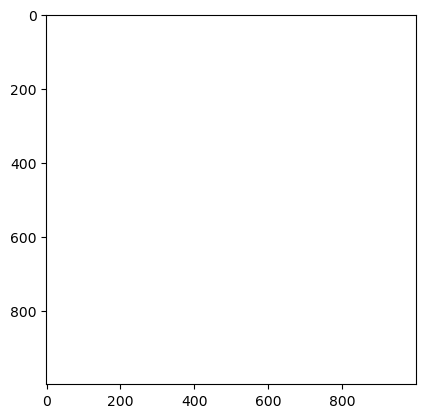

(1000, 1000, 3)


In [3]:
### This code below is for testing purposes only to check 
# the validity of the predicted data by the trained model before submission to Solafune Website
import tifffile
import matplotlib.pyplot as plt

BASE_PATH = './data/train_true_color/train_true_color_0.tif'

# show the image
img = tifffile.imread(BASE_PATH)
plt.imshow(img)
plt.show()

# show the image shape
print(img.shape)



FileNotFoundError: [Errno 2] No such file or directory: '/nfs/home/hussain/git_files/solafune-cloud/OUTPUT_Predictions/submission/evaluation_mask_873.tif'

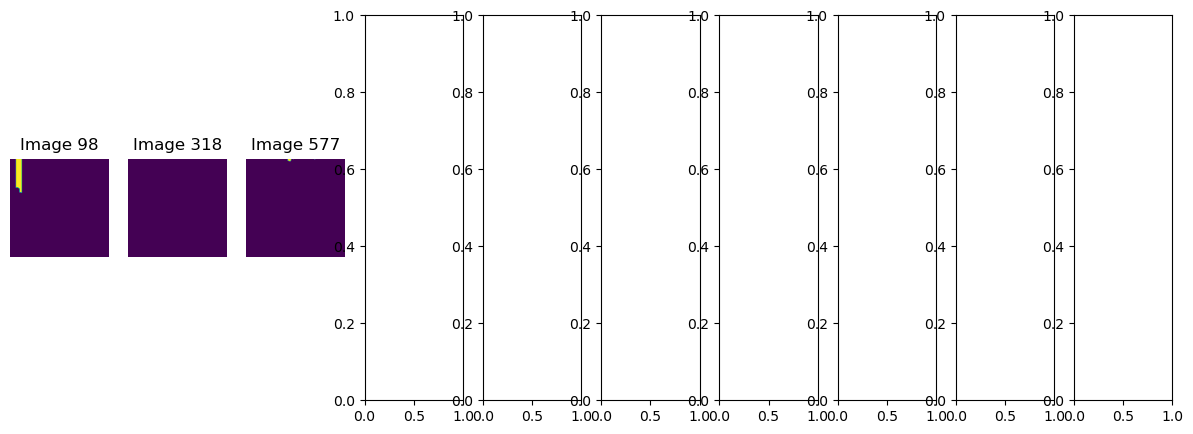

In [15]:
### This code below is for testing purposes only to check 
# the validity of the predicted data by the trained model before submission to Solafune Website
import tifffile
import matplotlib.pyplot as plt

BASE_PATH = './OUTPUT_Predictions/submission/'

fig, axes = plt.subplots(1, 10, figsize=(15, 5))  # Notice I changed NUM_IMAGES to 10 directly here

#generate 1- random numbers from 1 to 999
import random
randomlist = []
for i in range(0,10):
    n = random.randint(1,999)
    randomlist.append(n)
for idx, i in enumerate(randomlist):  # Removed 20 since you have 10 axes only
    # Construct the path to the image
    path = BASE_PATH + 'evaluation_mask_' + str(i) + '.tif'
    
    # Read the image
    img = tifffile.imread(path)
    
    # Display the image
    axes[idx].imshow(img)
    axes[idx].set_title('Image ' + str(i))
    axes[idx].axis('off')  # Hide axis labels

plt.tight_layout()
plt.show()


./OUTPUT_Predictions_guide/submission/evaluation_mask_3.tif
./data/evaluation_true_color/evaluation_true_color_3.tif
./OUTPUT_Predictions_guide/submission/evaluation_mask_7.tif
./data/evaluation_true_color/evaluation_true_color_7.tif
./OUTPUT_Predictions_guide/submission/evaluation_mask_8.tif
./data/evaluation_true_color/evaluation_true_color_8.tif


/tmp/ipykernel_12081/3201021392.py:22: RuntimeWarning: invalid value encountered in divide
  mask /= mask.max()


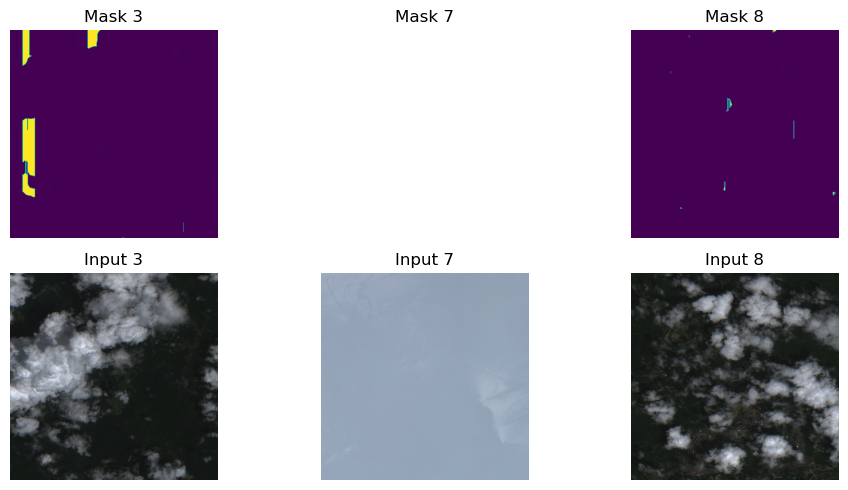

In [44]:
import tifffile
import matplotlib.pyplot as plt

BASE_PATH = './OUTPUT_Predictions_guide/submission/'
INPUT_IMGS = './data/evaluation_true_color/'
fig, axes = plt.subplots(2, 3, figsize=(10, 5))  # 2 rows and 3 columns for 3 pairs

# Specify the indices you want to display
indices_to_display = [3, 7, 8]  # Modify these to the indices you want to display

for idx, i in enumerate(indices_to_display):
    # Construct the path to the image
    mask_path = BASE_PATH + 'evaluation_mask_' + str(i) + '.tif'
    print(mask_path)
    input_path = INPUT_IMGS + 'evaluation_true_color_' + str(i) + '.tif'
    print(input_path)
    # Read the images
    mask = tifffile.imread(mask_path).astype(float)
    input_image = tifffile.imread(input_path).astype(float)

    # Normalize images to the range [0, 1]
    mask /= mask.max()
    input_image /= input_image.max()

    # Display the images in pairs
    row = idx // 3  # 0 or 1
    col = idx % 3   # 0, 1, or 2
    axes[row, col].imshow(mask)
    axes[row, col].set_title('Mask ' + str(i))
    axes[row, col].axis('off')

    axes[row+1, col].imshow(input_image)
    axes[row+1, col].set_title('Input ' + str(i))
    axes[row+1, col].axis('off')

plt.tight_layout()
plt.show()


./OUTPUT_Predictions/submission/evaluation_mask_30.tif
./data/evaluation_true_color/evaluation_true_color_30.tif
./OUTPUT_Predictions/submission/evaluation_mask_74.tif
./data/evaluation_true_color/evaluation_true_color_74.tif
./OUTPUT_Predictions/submission/evaluation_mask_947.tif
./data/evaluation_true_color/evaluation_true_color_947.tif


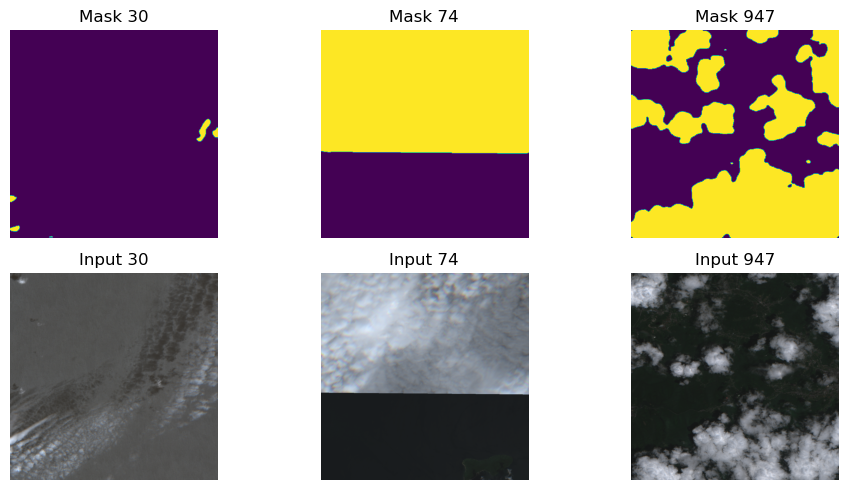

In [46]:
import tifffile
import matplotlib.pyplot as plt

BASE_PATH = './OUTPUT_Predictions/submission/'
INPUT_IMGS = './data/evaluation_true_color/'
fig, axes = plt.subplots(2, 3, figsize=(10, 5))  # 2 rows and 3 columns for 3 pairs

# Specify the indices you want to display
# indices_to_display = [3, 8, 16]  # Modify these to the indices you want to display


randomlist = []
for i in range(3):
    n = random.randint(1, 999)
    randomlist.append(n)
    
for idx, i in enumerate(randomlist):
    # Construct the path to the image
    mask_path = BASE_PATH + 'evaluation_mask_' + str(i) + '.tif'
    print(mask_path)
    input_path = INPUT_IMGS + 'evaluation_true_color_' + str(i) + '.tif'
    print(input_path)
    # Read the images
    mask = tifffile.imread(mask_path).astype(float)
    input_image = tifffile.imread(input_path).astype(float)

    # Normalize images to the range [0, 1]
    mask /= mask.max()
    input_image /= input_image.max()

    # Display the images in pairs
    row = idx // 3  # 0 or 1
    col = idx % 3   # 0, 1, or 2
    axes[row, col].imshow(mask)
    axes[row, col].set_title('Mask ' + str(i))
    axes[row, col].axis('off')

    axes[row+1, col].imshow(input_image)
    axes[row+1, col].set_title('Input ' + str(i))
    axes[row+1, col].axis('off')

plt.tight_layout()
plt.show()
